# Bayes decoding of neural activity

In this lesson, we will learn:

- What a bayesian decoder is and how to use it
- How to decode the position of an animal running in one or two dimensions
- How to use decoding techniques to investigate neural activity during sleep

### <font color='teal'> Naïve Bayes decoding </font>
_____

Bayesian decoders are a simple but powerful tool for decoding the value of a stimulus from the observed neural activity. 

Let $P(s)$ denote the probability of presentation of stimulus $s \in S$ and $P(r|s)$ the probability of obtaining a population response $r \in R$ when stimulus $s$ is presented. Using Bayes theorem, we can write the probability of the stimulus given the response:

$$P(s|r) = \frac{P(r|s)P(s)}{P(r)}$$

This equation gives the posterior probability of a response $r$ given that stimulus $s$ was presented. From this posterior p.d.f., bayesian decoding calculates a single prediction of the most likely stimulus, i.e., the maximum of the posterior distribution.

In the case of a neural population, $P(r|s)$ lives in a $N$ dimensional space, where $N$ is the number of observed neurons, and estimating such a p.d.f. can be dauting. However, we can make a **simplifying assumption that the activity of each neuron is independent**. In that case, we factorise the likelihood as:

$$P(r|s)  \prod_{i=1}^N P(r_i|s)$$

Note that since we are generally interested in finding the maximum of the posterior p.d.f., we often do not need to evaluate the denominator $P(r)$. Moreover, if the prior $P(s)$ is flat (i.e., a uniform distribution), the problem simplifies further and we are left eith the following expression for the **decoded stimulus value**

$$\hat{s} = \argmax_s \left(\prod_{i=1}^N P(r_i|s)\right)$$

To compute this value, all we need is to estimate the probability of observing a certain response given a stimulus, for each of the neurons. Usually, this corresponds to the number of spikes in a given interval, i.e., the **firing rate. This quantity, estimated throughout the stimulus, is none other than the tuning curve oof the neuron.**

We will now take a look at how we can use this procedure to decode the position of a running animal from it's place cells and how we can exploit some mild assumptions concerning the neural population to make this procedure faster.

### <font color='teal'> Decoding position on a linear track </font>

As an example, let's look at how we can decode the position of an animal on alinear track from the activity of its hippocampal place cells. We will start from simulated data for a clearer example, then move on to some real data. 

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from scipy.stats import pearsonr
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data

In [3]:
# Download lesson data
download_data('https://surfdrive.surf.nl/files/index.php/s/gOwG6DKD7IpkPze')

In [4]:
# Code: Data import 

data_file = 'data/linear_track_data.pickle'
with open(data_file, 'rb') as handle:
    data = pickle.load(handle)

# Spike_times → List of list with spike times of each neuron (100 x # spikes)
x, t, spike_times = data['x'], data['t'], data['spikes']
track_length = data['track_length']
fps  = data['fps']                   # Frames per second
n_cells = len(spike_times)

As you can see, many cells have place-related activity as their firing concentrates around a certain position in the track. We can use this information to decode position. To perform bayesian decoding, we need to estimate $P(r_i|s)$, which can be done by computing the firing rate maps of each cell

In [33]:
# Compute the position at which each spike was emitted
spike_positions = [np.interp(s, t, x) for s in spike_times]
space_bins = np.arange(0, track_length, 5) # Binning of 5 cms

# Compute the histogram for each cell
spikes_hist = np.asarray([np.histogram(s, space_bins)[0] for s in spike_positions])

# 'Occupancy histogram' 
# We need this to normalise the firing rate maps
occupancy = np.histogram(x, space_bins)[0] / fps
firing_rate_maps = spikes_hist / occupancy

Text(0, 0.5, '# Cell')

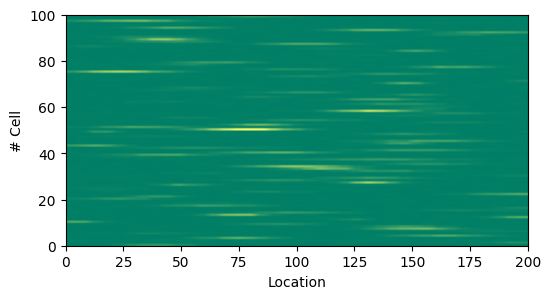

In [16]:
# Let's look at the rate maps
plt.figure(figsize=(6,3))
plt.imshow(firing_rate_maps, cmap='summer', extent = [0, 200, 0, n_cells])
plt.xlabel('Location')
plt.ylabel('# Cell')

In [27]:
# Extract the spike count for each neuron at each time step
spike_counts = np.asarray([np.histogram(s,t)[0] for s in spike_times])

# We transpose the matrix to have it in a more familiar shape = [samples x features]
spike_counts = spike_counts.T #[5026 x 100]

Now, we can apply the equations we derived to decode the position of the animal at each time instant

$$P(r|s) = \prod_{i=1}^N P(r_i|s)$$

$$\hat{s} = \argmax_s \left(\prod_{i=1}^N P(r_i|s)\right)$$

_____

For the `poisson.logpmf` function the arguments are `k`and `mu` which correspond to 

$$log P = log \left( \frac{e^{-\mu}\mu^k}{k!}\right)$$

where then $\mu$ is the firing rate and $k$ the number of events
_____

In [35]:
# Decoding
from scipy.stats import poisson

# Get rid of the last time point such that `true_x` has the same length as the binned spikes
true_x = x[:-1] 
decoding_times = t[:-1]

x_decoded = np.zeros_like(true_x)

for t_bin in tqdm(range(len(decoding_times))):
    
    # Check if the time bin has spikes
    if sum(spike_counts[t_bin, :]) > 0:
        posterior = np.empty(firing_rate_maps.shape[-1])
        for i in range(len(posterior)):

            # Note that we work with the log such that we can sum probabilities
            # instead of multiplying them
            posterior[i] = sum(poisson.logpmf(spike_counts[t_bin,:], firing_rate_maps[:, i] / fps), pow(1, -15))

        x_decoded[t_bin] = space_bins[np.argmax(posterior)]
    else:
        x_decoded[t_bin] = np.nan

100%|██████████| 5026/5026 [00:11<00:00, 434.88it/s]


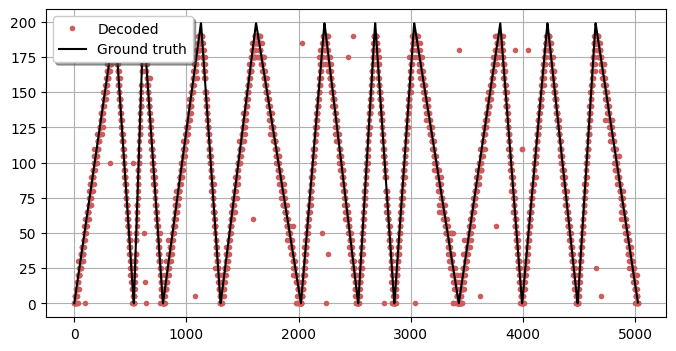

Median error: 3.357155002380459 cm


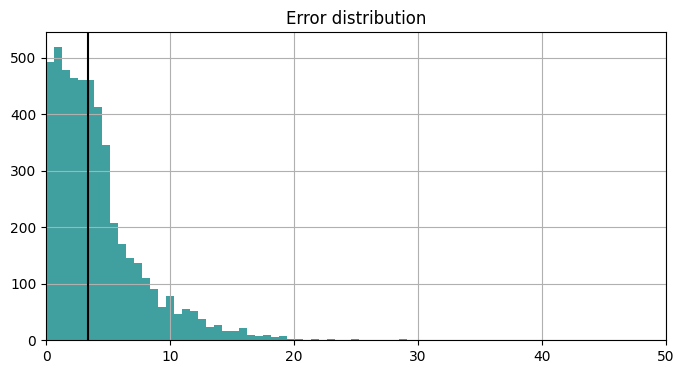

In [55]:
# Plot the resulting, prediction/decoding
plt.figure(figsize=(8,4))
plt.plot(x_decoded, '.', color='indianred', label='Decoded')
plt.plot(true_x, 'k', label='Ground truth')
plt.grid()
plt.legend(shadow=True)
plt.show()

# Error distribution
mse = np.sqrt((true_x - x_decoded)**2)
plt.figure(figsize=(8,4))
plt.hist(mse, bins=300, color='teal', alpha=0.75)
plt.axvline(x = np.nanmedian(mse), c='k')
plt.grid()
plt.xlim([0,50])
plt.title('Error distribution')
print(f'Median error: {np.nanmedian(mse)} cm')

Our decoder can predict the animal position with a median error of about 6cm. In the exercises, we'll explore how is this impacted by the sample size, number of cells and noise.
_____

#### **Vectorization of the bayes decoder**

Above we calculated the (log) posterior distributions by looping both on the time bins and the spatial bins but we can do better by leveraging the analytical expression of the posterior distribution and rewrite the code using linear algebra.

First, since the probability $P(n_i|x)$ of observing $n_i$ spikes from neuron $i$, given a position $x$, is assumed to be poissonian, we can write it as 

$$P(n_i|x) = \frac{[\tau f_i(x)]^{n_i}}{n_i!}e^{-\tau f_i(x)}$$

where $f_i(x)$ is the average firing rate of the neuron in position $x$, i.e., the firing rate map value. For the whole population, we then have

$$P(n|x) = \prod_{i=1}^NP(n_i|x) = \prod_{i=1}^N \frac{[\tau f_i(x)]^{n_i}}{n_i!}e^{-\tau f_i(x)}$$

Yielding the posterior probability given by

$$P(x|n) = C \times P(x) \times \prod_{i=1}^N \frac{[\tau f_i(x)]^{n_i}}{n_i!}e^{-\tau f_i(x)}$$

where $C$ is a normalization constant and $P(x)$ the prior.

Taking the log of the posterior yields

$$log(P(x|n)) = \sum_{i=1}^N [n_i log(f_i(x)) - \tau f_i(x)] + log(\tau) + log(n!) + C + P(x)$$

We can rewrite the posterior calculation using the matrices `Sp` (n_time_bins x n_space_bins), `Rm` (n_cell x n_space_bins) and `Pr` (1 x n_space_bins)

`Pt = Sp @ np.log(Rm) - dt*np.sum(Rm, axis = 0) + np.log(Pr)`

With $dt = 1/fps$

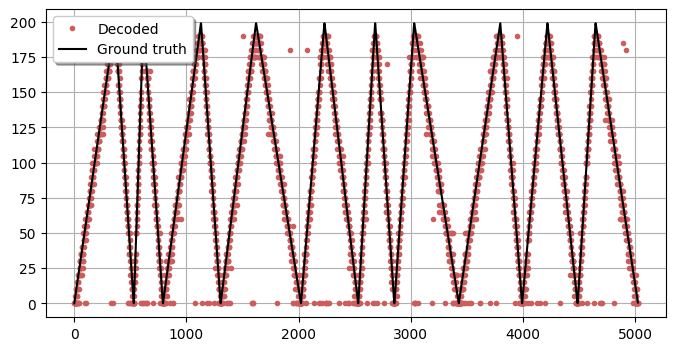

Median error: 3.7851270758785205 cm


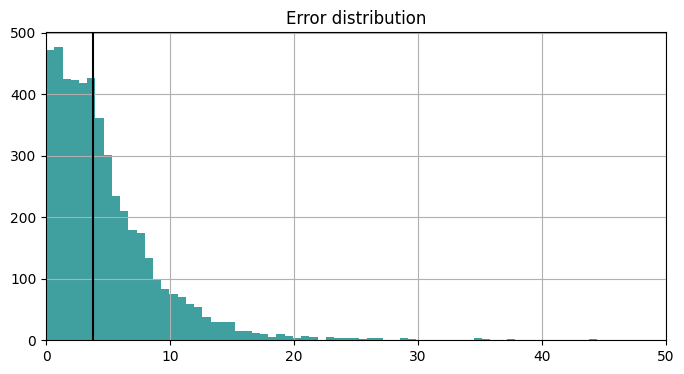

In [60]:
epsilon = pow(1, -10)
log_posteriors = spike_counts @ np.log(firing_rate_maps + epsilon) - (1/fps) * np.sum(firing_rate_maps, axis = 0)
x_parallel = [space_bins[np.argmax(P)] for P in log_posteriors]

# Plot the resulting, prediction/decoding
plt.figure(figsize=(8,4))
plt.plot(x_parallel, '.', color='indianred', label='Decoded')
plt.plot(true_x, 'k', label='Ground truth')
plt.grid()
plt.legend(shadow=True)
plt.show()

# Error distribution
mse = np.sqrt((true_x - x_parallel)**2)
plt.figure(figsize=(8,4))
plt.hist(mse, bins=300, color='teal', alpha=0.75)
plt.axvline(x = np.nanmedian(mse), c='k')
plt.grid()
plt.xlim([0,50])
plt.title('Error distribution')
print(f'Median error: {np.nanmedian(mse)} cm')

### <font color='teal'> Sequential reactivation during sleep</font>
_____

The use of deconding methods is not limited to measure the amount of information that a neural population carries about a specific set of stimuli or to predict what stimulus is preent at a given time. It is extremely useful to interpret the content of neural activity when no stimulus is present, that is, this activity is generated spontaneously. 

In the case of the hippocampus, it has been extensively observed that during rest periods (either when the animal is standing still or whilst sleeping) place cells reactivate specific patterns of activity corresponding to sequences of locations in the environment. 

This phenomenon called **replay** is thought to be critical for the formation of memories, for the aquisition and consolidation of knowledge and for reorganising information in the brain.

Here, we want to simulate the oocurence of such reactivation events. Reactivation patterns can be

- Neural activity will represent a series of locations in the order they appear on the linear track
- Neural activity representing locations on the linear track, but randomly drawn showing no clear order 

In [ ]:
# Generate (fake) data
n_events = 200          # Number of reactivation patterns
event_duration = 100    # ... in bins
sampling_rate = 100     
t_react = np.arange(0, 100)

noise_x_react = 5
noise_t_react = 5 
noise_firing_rate = 0.1

reactivation_patterns = np.zeros((n_events, event_duration))
spikes_react = np.zeros((n_events, n_cells, event_duration))

for event in range(n_events):
    if (event < n_events // 2):
        